## Predicting

**Importing librairies**


In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd
from tqdm import tqdm

**Denne nettsiden snakker litt om hvordan jobbe med ubalanserte datasett**

https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [4]:
Filename = "..\data\_tarefelt1.csv"
data = pd.read_csv(Filename)


In [5]:
Filename = "..\data\_tarefelt2.csv"
data2 = pd.read_csv(Filename)

In [6]:
data2.columns

Index(['Unnamed: 0', 'band_0', 'band_1', 'band_2', 'band_3', 'band_4',
       'band_5', 'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11',
       'band_12', 'band_13', 'band_14', 'band_15', 'band_16', 'band_17',
       'band_18', 'band_19', 'band_20', 'band_21', 'band_22', 'band_23',
       'band_24', 'band_25', 'band_26', 'band_27', 'band_28', 'band_29',
       'band_30', 'band_31', 'band_32', 'band_33', 'band_34', 'band_35',
       'band_36', 'band_37', 'band_38', 'band_39', 'band_40', 'band_41',
       'band_42', 'band_43', 'band_44', 'band_45', 'band_46', 'band_47',
       'band_48', 'band_49', 'band_50', 'band_51', 'band_52', 'band_53',
       'band_54', 'band_55', 'band_56', 'band_57', 'band_58', 'band_59',
       'band_60', 'band_61', 'band_62', 'band_63', 'band_64', 'band_65', 'lat',
       'lon', 'geometry', 'label'],
      dtype='object')

In [7]:
#Removes 90% of data labeled 0
data = data.drop(data[data['label'] == 0].sample(frac=.90).index)

In [8]:
data_x = data.drop(["Unnamed: 0"], axis=1)
data_x = data_x.drop(["label"], axis=1)
data_x = data_x.drop(columns = "geometry")
data_y = data.label

**Scale dataset**

In [ ]:
""" scaler = StandardScaler()
scaler.fit(data_x) 
scaled_data_x = scaler.transform(data_x)

print(scaled_data_x.shape)
data_x = pd.DataFrame(scaled_data_x, index= data_x.index, columns=data_x.columns)
data_x.lat
 """

' scaler = StandardScaler()\nscaler.fit(data_x) \nscaled_data_x = scaler.transform(data_x)\n\nprint(scaled_data_x.shape)\ndata_x = pd.DataFrame(scaled_data_x, index= data_x.index, columns=data_x.columns)\ndata_x.lat\n '

In [9]:
scalable_columns = list(data_x.columns)
scalable_columns.remove("lat")
scalable_columns.remove("lon")

temp = data_x.drop(["lat"], axis=1)
temp = temp.drop(["lon"], axis=1)

scaler = StandardScaler()
scaler.fit(temp) 
scaled_data_x = scaler.transform(temp)

scaled_data_x_df = pd.DataFrame(scaled_data_x, index= data_x.index, columns=scalable_columns)
#scaled_data_x_df["lon"] = data_x.lon
#scaled_data_x_df["lat"] = data_x.lat

#data_x = scaled_data_x_df

**Splitting Data**

In [10]:
X_train, X_test ,y_train, y_test = train_test_split( scaled_data_x_df, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Definerer en batch generator**

In [11]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    iterable_X: X frame to be iterated over
    iterable_y: y frame to be iterated over
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [12]:
""" scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)
scaled_X_val = scaler.transform(X_val)
X_val  = pd.DataFrame(scaled_X_val, index= X_val.index, columns=X_val.columns) """

' scaler = StandardScaler()\nscaler.fit(X_train) \nscaled_X_train = scaler.transform(X_train)\nX_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)\nscaled_X_test = scaler.transform(X_test)\nX_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)\nscaled_X_val = scaler.transform(X_val)\nX_val  = pd.DataFrame(scaled_X_val, index= X_val.index, columns=X_val.columns) '

**Training the model**  


In [13]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))


classes = np.unique(y_train)
accuracy =[]
ROUNDS = 100
batch_size = 10000
for _ in tqdm(range(ROUNDS), total=ROUNDS):
    #X_train, y_train = shuffle(X_train, y_train)
    batcherator = batch(X_train, y_train, batch_size)
    
    for index, (X, target) in enumerate(batcherator):

        #scaler = StandardScaler()
        #scaler.fit(X) 
        #X = scaler.transform(X)
        #test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


**Evaluating Model**


[[9362 4911]
 [3459 4523]]


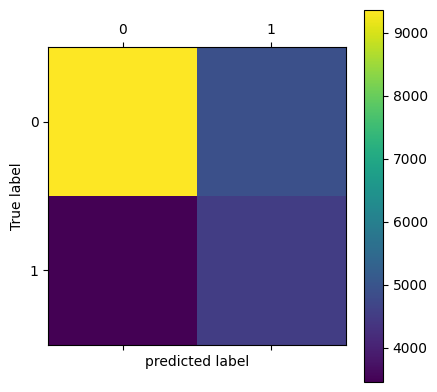

In [14]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

print(conf_mat)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [15]:
y_predicted = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.62


In [658]:
y_predicted == y_val
X_val

,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,...,band_56,band_57,band_58,band_59,band_60,band_61,band_62,band_63,band_64,band_65
413764,0.0,0.0,0.0,-0.249069,-0.247272,-0.297030,-0.269519,-0.272741,-0.267572,-0.284768,...,0.129039,-0.375849,-0.380197,0.191670,0.647086,-0.404870,0.394920,0.740450,0.423596,0.006575
431369,0.0,0.0,0.0,-0.240382,-0.229504,-0.211925,-0.247747,-0.267971,-0.270296,-0.249439,...,-0.193747,-0.176217,-0.089512,-0.116455,0.132675,-0.290611,-0.212487,-0.560000,-0.479437,-0.210210
843107,0.0,0.0,0.0,4.743153,4.829354,4.970735,5.108064,5.138266,4.847427,4.781513,...,1.158614,1.087168,0.905865,0.773954,0.525252,0.114822,-0.252257,-0.479560,-0.949838,0.415371
167643,0.0,0.0,0.0,-0.325511,-0.277872,-0.218182,-0.289616,-0.299772,-0.271204,-0.263739,...,-0.090789,0.556718,0.239344,-0.220781,0.095447,-0.356955,0.091217,-0.127634,-0.445101,0.319366
205780,0.0,0.0,0.0,-0.208242,-0.244311,-0.245716,-0.227650,-0.234579,-0.257586,-0.220840,...,0.351650,0.539606,0.459560,0.934082,-0.165143,0.147994,1.490422,0.830945,-0.053672,0.446341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311029,0.0,0.0,0.0,3.576535,3.542183,3.421319,3.322794,3.166580,3.361226,3.449964,...,0.735654,0.365641,0.318622,0.494943,0.230819,0.387568,-0.219718,-1.200170,-0.383296,-1.191940
772438,0.0,0.0,0.0,-0.211716,-0.229504,-0.218182,-0.205879,-0.215498,-0.233981,-0.198970,...,0.176344,-0.064993,-0.115938,0.140720,-0.439270,0.103765,-0.122099,-0.151095,-0.201316,0.362723
753411,0.0,0.0,0.0,-0.176970,-0.225556,-0.206918,-0.303014,-0.240939,-0.227626,-0.233457,...,-0.213225,-0.070697,-0.115938,-0.094620,-0.205754,-1.230480,-0.617425,0.468964,-0.125777,-1.436598
675104,0.0,0.0,0.0,4.957713,4.870812,4.715419,4.536979,4.599233,4.830177,4.885817,...,2.505411,2.139514,1.898305,1.649807,2.325692,1.191064,0.423845,0.197479,-0.019336,0.585703


In [659]:
unique, counts = np.unique(y_predicted, return_counts=True)
print(unique)
print(counts)

[0. 1.]
[13775  8480]


In [660]:
y_test.value_counts()


0.0    14261
1.0     7994
Name: label, dtype: int64

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [665]:
y_predicted = clf.predict(scaled_data_x_df)
X = data_x.copy()
X["label"] = y_train
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))



df_no_seaweed = X[X["y_predicted"] == False]
df_seaweed = X[X["y_predicted"] == 1]
df_true_seaweed = X[X["label"] == True]
df_correct_prediction = X[X["label"] == X["y_predicted"]]
df_correct_prediction = df_correct_prediction[df_correct_prediction["y_predicted"] == 0]

In [666]:
df_correct_prediction[["label", "y_predicted"]]

,label,y_predicted
84,0.0,0.0
96,0.0,0.0
104,0.0,0.0
107,0.0,0.0
128,0.0,0.0
...,...,...
999862,0.0,0.0
999915,0.0,0.0
999954,0.0,0.0
999970,0.0,0.0


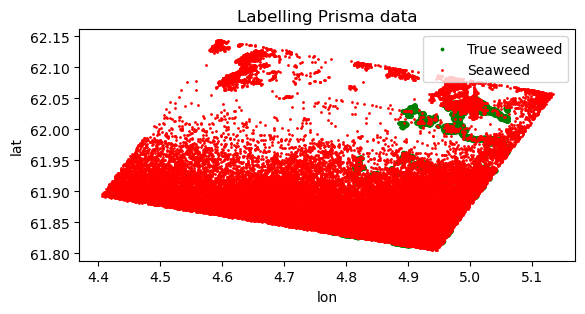

In [667]:
fig, ax = plt.subplots()
#df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 3)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)
#df_correct_prediction.plot(ax = ax, color = "red", label = "Correct prediction", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()